# Can we Predict Loneliness?

## Importing Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

## Load Files

In [2]:

file_path = "C:\\Users\\medasud\\Downloads\\DSDP Project 2 Loneliness\\covidpanel_us_stata_jan_17_2023.dta"
coviddata = pd.read_stata(file_path)

print(coviddata.head())

       uasid    uashhid survhhid  wave  survey_source  final_weight  \
0  140100007  140100007       .n   1.0          230.0      2.757085   
1  140100010  140100010       .n   1.0          230.0      0.881547   
2  140100011  140100011       .n   1.0          230.0      2.791393   
3  140100035  140100035       .n   1.0          230.0      1.087637   
4  140100038  140100038       .n   1.0          230.0      2.889530   

  uasmembers                   sampletype                    batch  \
0        0.0  1 Nationally Representative  1 ASDE 2014/01 Nat.Rep.   
1        0.0  1 Nationally Representative  1 ASDE 2014/01 Nat.Rep.   
2        0.0  1 Nationally Representative  1 ASDE 2014/01 Nat.Rep.   
3        0.0  1 Nationally Representative  1 ASDE 2014/01 Nat.Rep.   
4        0.0  1 Nationally Representative  1 ASDE 2014/01 Nat.Rep.   

     primary_respondent  ... vc004d vc005_randomizer vc005a  vc005b  vc005c  \
0  1 Primary respondent  ...    NaN              NaN    NaN     NaN     N

In [3]:
coviddata.shape

(208825, 4222)

In [4]:
#create a copy of the dataframe for analysis
newdf = coviddata.copy()

In [5]:
#this is the variable for loneliness in response to 'how often have you felt lonely?'
newdf['cr058'].value_counts()

cr058
1 Not at all or less than 1 day    109047
2 1-2 days                          27236
3 3-4 days                          12038
4 5-7 days                           9969
Name: count, dtype: int64

In [6]:
newdf['cr058'] = newdf['cr058'].astype(str).str.strip()

#rename values
newdf.loc[newdf['cr058'] == '1 Not at all or less than 1 day', 'cr058'] = 'Not at all or less than 1 day'
newdf.loc[newdf['cr058'] == '2 1-2 days', 'cr058'] = '1-2 days'
newdf.loc[newdf['cr058'] == '3 3-4 days', 'cr058'] = '3-4 days'
newdf.loc[newdf['cr058'] == '4 5-7 days', 'cr058'] = '5-7 days'

In [7]:
newdf['race'].value_counts()

race
1 White Only                               162365
2 Black Only                                17012
4 Asian Only                                11229
6 Mixed                                     10969
3 American Indian or Alaska Native Only      4343
5 Hawaiian/Pacific Islander Only             1408
Name: count, dtype: int64

In [8]:
newdf['cr071'].value_counts()

cr071
180.0    4615
200.0    4545
150.0    4020
160.0    4000
165.0    3644
         ... 
376.0       1
61.0        1
359.0       1
78.0        1
66.0        1
Name: count, Length: 332, dtype: int64

## Creating Variables

### Race

In [9]:
columns_to_view = ['race', 'hisplatino', 'hisplatino_group', 'asian', 'pacific', 'nativeamer', 'black', 'white']

#select the columns for race and view them
selected_columns_df = newdf[columns_to_view]
print(selected_columns_df.tail(10))

                race hisplatino hisplatino_group  asian pacific nativeamer  \
208815       6 Mixed       0 No              NaN  1 Yes    0 No       0 No   
208816  1 White Only       0 No              NaN   0 No    0 No       0 No   
208817  4 Asian Only       0 No              NaN  1 Yes    0 No       0 No   
208818  4 Asian Only       0 No              NaN  1 Yes    0 No       0 No   
208819  1 White Only       0 No              NaN   0 No    0 No       0 No   
208820  2 Black Only       0 No              NaN   0 No    0 No       0 No   
208821  1 White Only      1 Yes        1 Mexican   0 No    0 No       0 No   
208822       6 Mixed       0 No              NaN  1 Yes    0 No      1 Yes   
208823  2 Black Only       0 No              NaN   0 No    0 No       0 No   
208824  1 White Only       0 No              NaN   0 No    0 No       0 No   

        black  white  
208815  1 Yes   0 No  
208816   0 No  1 Yes  
208817   0 No   0 No  
208818   0 No   0 No  
208819   0 No  1 Yes  
208

In [10]:
#the 'race' column did not have any category for hispanic/latino. All records in 'hisplatino' with 
#value '1 Yes' had value '1 White Only' in race, so we represent this group in 'race_combined'

#convert columns to string to avoid categorical issues
newdf['race'] = newdf['race'].astype(str)
newdf['hisplatino'] = newdf['hisplatino'].astype(str)

#create a new column race_combined and initially copy the values from race
newdf['race_combined'] = newdf['race'].astype(str)

condition = (newdf['race'] == '1 White Only') & (newdf['hisplatino'] == '1 Yes')
newdf.loc[condition, 'race_combined'] = newdf.loc[condition, 'hisplatino']

#identify rows where race is missing. This is mostly for hispanic/latino individuals as the 'race' column
#does not record that ethnic group, or they are classed as '1 White Only'
missing_race = newdf['race'].isnull() | (newdf['race'] == '1 White Only')
#we want to select values where they are hisp/lat
hisplatino_yes = newdf['hisplatino'] == '1 Yes'
#combine the above conditions
condition = missing_race & hisplatino_yes

#update race_combined based on hisplatino for rows matching the condition
newdf.loc[condition, 'race_combined'] = newdf.loc[condition, 'hisplatino']


In [11]:
newdf['race_combined'] = newdf['race_combined'].astype(str).str.strip()

#rename values
newdf.loc[newdf['race_combined'] == '1 Yes', 'race_combined'] = 'Hispanic/Latino'
newdf.loc[newdf['race_combined'] == '1 White Only', 'race_combined'] = 'White Only'
newdf.loc[newdf['race_combined'] == '2 Black Only', 'race_combined'] = 'Black Only'
newdf.loc[newdf['race_combined'] == '3 American Indian or Alaska Native Only', 'race_combined'] = 'American Indian or Alaska Native Only'
newdf.loc[newdf['race_combined'] == '4 Asian Only', 'race_combined'] = 'Asian Only'
newdf.loc[newdf['race_combined'] == '5 Hawaiian/Pacific Islander Only', 'race_combined'] = 'Hawaiian/Pacific Islander Only'
newdf.loc[newdf['race_combined'] == '6 Mixed', 'race_combined'] = 'Mixed'


In [12]:
columns_to_view = ['race', 'hisplatino', 'hisplatino_group', 'asian', 'pacific', 'nativeamer', 'black', 'white', 'race_combined']

selected_columns_df = newdf[columns_to_view]
print(selected_columns_df.tail(10))

                race hisplatino hisplatino_group  asian pacific nativeamer  \
208815       6 Mixed       0 No              NaN  1 Yes    0 No       0 No   
208816  1 White Only       0 No              NaN   0 No    0 No       0 No   
208817  4 Asian Only       0 No              NaN  1 Yes    0 No       0 No   
208818  4 Asian Only       0 No              NaN  1 Yes    0 No       0 No   
208819  1 White Only       0 No              NaN   0 No    0 No       0 No   
208820  2 Black Only       0 No              NaN   0 No    0 No       0 No   
208821  1 White Only      1 Yes        1 Mexican   0 No    0 No       0 No   
208822       6 Mixed       0 No              NaN  1 Yes    0 No      1 Yes   
208823  2 Black Only       0 No              NaN   0 No    0 No       0 No   
208824  1 White Only       0 No              NaN   0 No    0 No       0 No   

        black  white    race_combined  
208815  1 Yes   0 No            Mixed  
208816   0 No  1 Yes       White Only  
208817   0 No   0 No 

In [13]:
selected_columns_df['race_combined'].value_counts()

race_combined
White Only                               139147
Hispanic/Latino                           23218
Black Only                                17012
Asian Only                                11229
Mixed                                     10969
American Indian or Alaska Native Only      4343
nan                                        1499
Hawaiian/Pacific Islander Only             1408
Name: count, dtype: int64

In [14]:
selected_columns_df

,race,hisplatino,hisplatino_group,asian,pacific,nativeamer,black,white,race_combined
0,1 White Only,0 No,NaN,0 No,0 No,0 No,0 No,1 Yes,White Only
1,1 White Only,0 No,NaN,0 No,0 No,0 No,0 No,1 Yes,White Only
2,1 White Only,0 No,NaN,0 No,0 No,0 No,0 No,1 Yes,White Only
3,1 White Only,0 No,NaN,0 No,0 No,0 No,0 No,1 Yes,White Only
4,1 White Only,0 No,NaN,0 No,0 No,0 No,0 No,1 Yes,White Only
...,...,...,...,...,...,...,...,...,...
208820,2 Black Only,0 No,NaN,0 No,0 No,0 No,1 Yes,0 No,Black Only
208821,1 White Only,1 Yes,1 Mexican,0 No,0 No,0 No,0 No,1 Yes,Hispanic/Latino
208822,6 Mixed,0 No,NaN,1 Yes,0 No,1 Yes,0 No,1 Yes,Mixed
208823,2 Black Only,0 No,NaN,0 No,0 No,0 No,1 Yes,0 No,Black Only


Number of Household Members

In [15]:
#Number of household UAS members besides the respondent
newdf['uasmembers'].value_counts()

uasmembers
0.0    136820
1.0     53961
2.0     12064
3.0      4389
4.0      1012
5.0       565
6.0        14
Name: count, dtype: int64

In [16]:
newdf['primary_respondent'].value_counts()

primary_respondent
1 Primary respondent    172349
0 Added member           36476
Name: count, dtype: int64

In [17]:
newdf['gender'].value_counts()

gender
0 Female    122739
1 Male       86085
Name: count, dtype: int64

In [18]:
newdf['dateofbirth_year'].value_counts()

dateofbirth_year
1960.0    4931
1961.0    4917
1957.0    4818
1954.0    4783
1955.0    4708
          ... 
2003.0      26
1910.0      26
1919.0      18
2004.0       9
1923.0       1
Name: count, Length: 84, dtype: int64

In [19]:
newdf['age'].value_counts()

age
59.0     4775
65.0     4712
60.0     4596
64.0     4521
62.0     4402
         ... 
100.0       6
98.0        4
103.0       2
104.0       2
112.0       1
Name: count, Length: 89, dtype: int64

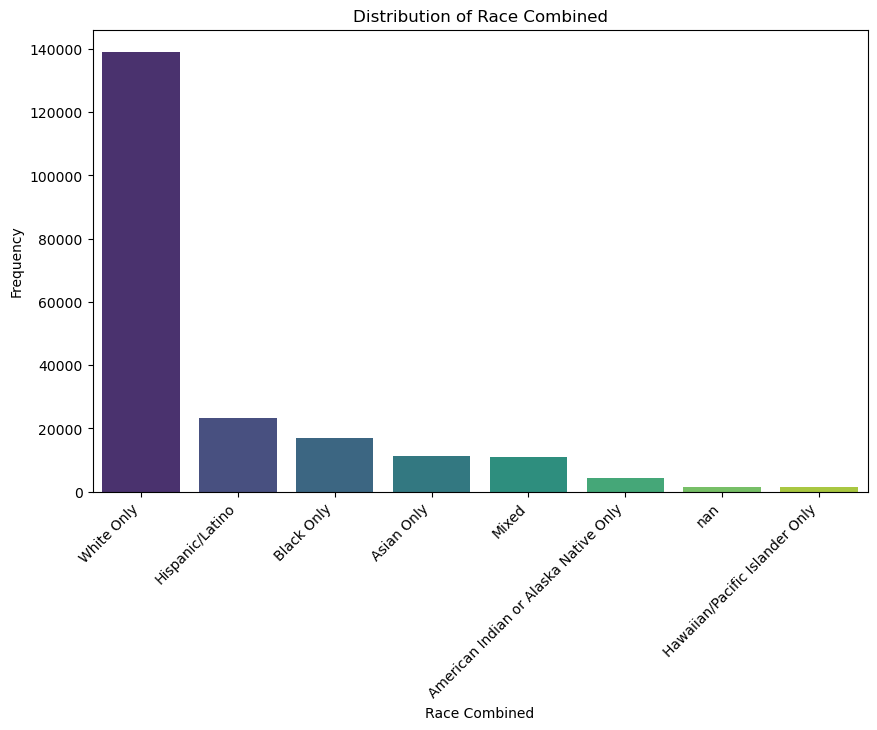

In [20]:
race_counts = newdf['race_combined'].value_counts()

plt.figure(figsize=(10, 6))
sns.countplot(data=newdf, x='race_combined', order=race_counts.index, palette='viridis')
plt.title('Distribution of Race Combined')
plt.xlabel('Race Combined')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

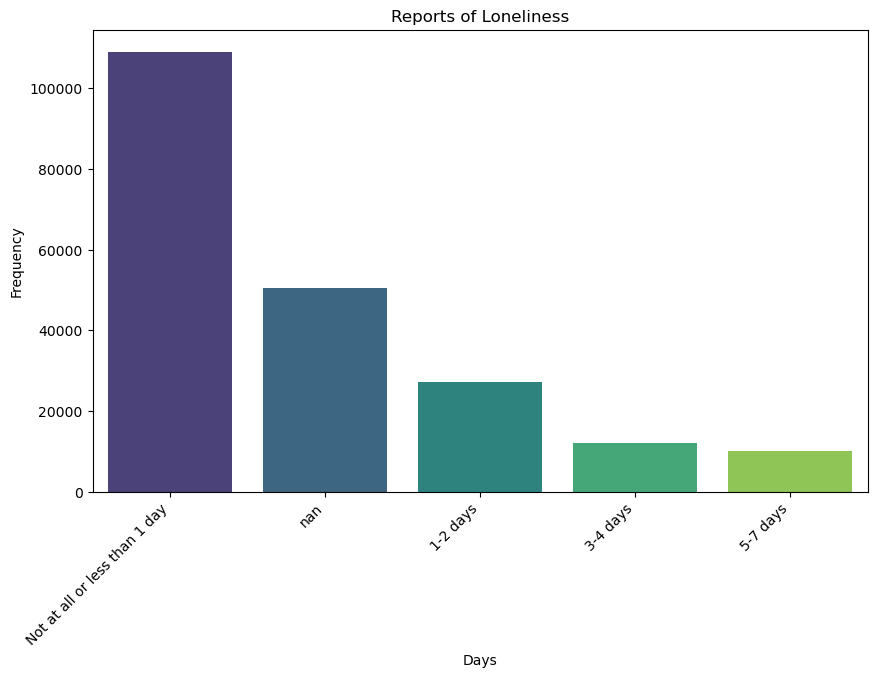

In [21]:
lone_counts = newdf['cr058'].value_counts()

plt.figure(figsize=(10, 6))
sns.countplot(data=newdf, x='cr058', order=lone_counts.index, palette='viridis')
plt.title('Reports of Loneliness')
plt.xlabel('Days')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

In [26]:
newdf['cr058'].isnull().sum()

50535

In [23]:
#replace empty strings with NaN in cr058
newdf['cr058'] = newdf['cr058'].replace('nan', pd.NA)

In [27]:
newdf['cr058'].isnull().sum()

50535

In [28]:
newdf.shape

(208825, 4223)

dropping records where cr058 is null

In [29]:
newdf = newdf.dropna(subset=['cr058'])

In [30]:
newdf.shape

(158290, 4223)

In [31]:
newdf['hhincome'].value_counts()

hhincome
15 100,000 to 149,999    22746
14 75,000 to 99,999      22343
16 150,000 or more       18970
13 60,000 to 74,999      17483
12 50,000 to 59,999      12732
11 40,000 to 49,999      11855
10 35,000 to 39,999       7621
9 30,000 to 34,999        7384
8 25,000 to 29,999        7125
7 20,000 to 24,999        6849
6 15,000 to 19,999        5531
1 Less than $5,000        5444
4 10,000 to 12,499        4067
5 12,500 to 14,999        3222
3 7,500 to 9,999          2434
2 5,000 to 7,499          2158
Name: count, dtype: int64

In [32]:
income_mapping = {
    '1 Less than $5,000': 'Less than $20,000',
    '2 5,000 to 7,499': 'Less than $20,000',
    '3 7,500 to 9,999': 'Less than $20,000',
    '4 10,000 to 12,499': 'Less than $20,000',
    '5 12,500 to 14,999': 'Less than $20,000',
    '6 15,000 to 19,999': 'Less than $20,000',
    '7 20,000 to 24,999': '$20,000 to $49,999',
    '8 25,000 to 29,999': '$20,000 to $49,999',
    '9 30,000 to 34,999': '$20,000 to $49,999',
    '10 35,000 to 39,999': '$20,000 to $49,999',
    '11 40,000 to 49,999': '$20,000 to $49,999',
    '12 50,000 to 59,999': '$50,000 to $99,999',
    '13 60,000 to 74,999': '$50,000 to $99,999',
    '14 75,000 to 99,999': '$50,000 to $99,999',
    '15 100,000 to 149,999': '$100,000 to $149,999',
    '16 150,000 or more': '$150,000 or more'
}


In [33]:
newdf['hhincome'] = newdf['hhincome'].map(income_mapping)
newdf['hhincome'].value_counts()

hhincome
$50,000 to $99,999      52558
$20,000 to $49,999      40834
Less than $20,000       22856
$100,000 to $149,999    22746
$150,000 or more        18970
Name: count, dtype: int64

In [34]:
newdf['ei002'].value_counts() #question: worried you would run out of food

ei002
2 No        147287
1 Yes         8357
3 Unsure      2410
Name: count, dtype: int64

In [35]:
#remove the numbers and retain the state names
newdf['statereside'] = newdf['statereside'].str.replace(r'^\d+\s', '', regex=True)

In [37]:
newdf['statereside'].value_counts()

statereside
California              49460
Ohio                     7177
Pennsylvania             6492
Florida                  6092
Texas                    5974
Michigan                 5009
New York                 4739
Illinois                 4233
Georgia                  4072
Wisconsin                4006
North Carolina           3984
Virginia                 3848
Indiana                  3794
Missouri                 2995
Tennessee                2974
Washington               2797
Kansas                   2692
Iowa                     2395
Kentucky                 2323
Arkansas                 2260
Arizona                  2080
Minnesota                2070
Alabama                  2012
West Virginia            1992
New Jersey               1969
South Carolina           1700
Colorado                 1513
Massachusetts            1445
Oklahoma                 1437
Oregon                   1421
Mississippi              1366
Montana                  1258
Utah                     110

In [38]:
export = newdf[['uasid','cr058', 'wave', 'statereside', 'hhincome', 'ei002']]

In [39]:
export.to_csv('lonelydata.csv', index=False)


In [40]:
newdf['disabled'].value_counts()

disabled
0 No     145050
1 Yes     13158
Name: count, dtype: int64

In [41]:
#convert start_date to datetime 
newdf['start_date'] = pd.to_datetime(newdf['start_date'])

#sort values by start_date to get the earliest date first
newdf_sorted = newdf.sort_values(by='start_date')

print(newdf_sorted['start_date'])

24561    2020-04-29
24930    2020-04-29
21451    2020-04-29
20883    2020-04-29
20603    2020-04-29
            ...    
175520   2021-07-19
176778   2021-07-19
178721   2021-07-19
175735   2021-07-19
176927   2021-07-19
Name: start_date, Length: 158290, dtype: datetime64[ns]


In [42]:
#convert start_date to datetime 
newdf['end_date'] = pd.to_datetime(newdf['end_date'])

#sort values by start_date to get the earliest date first
newdf_sorted = newdf.sort_values(by='end_date',ascending=False)

print(newdf_sorted['end_date'])

175596   2021-07-19
176927   2021-07-19
175443   2021-07-19
176706   2021-07-19
177374   2021-07-19
            ...    
177618          NaT
177864          NaT
178491          NaT
179003          NaT
179007          NaT
Name: end_date, Length: 158290, dtype: datetime64[ns]


In [43]:
newdf['start_year'].value_counts()

start_year
2020.0    107637
2021.0     50653
Name: count, dtype: int64

Longitudinal Analysis

In [44]:
#number of unique participants
newdf['uasid'].nunique()
#the 200,000+ observations are recorded over time for these ~8000 participants
#so it is possible to track them through time

8303

In [45]:

# Counter to keep track of the number of respondents plotted
counter = 0
max_plots = 6  # Number of respondents to plot

# Plot cr058 over time for the first 6 respondents
for name, group in grouped:
    plt.figure(figsize=(10, 6))
    plt.plot(group['start_date'], group['cr058'], marker='o', linestyle='-', label=f'Respondent {name}')
    plt.title(f'cr058 Over Time for Respondent {name}')
    plt.xlabel('Start Date')
    plt.ylabel('cr058')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Increment the counter and check if we have plotted 6 respondents
    counter += 1
    if counter >= max_plots:
        break


NameError: name 'grouped' is not defined

In [46]:
newdf['cr054s10'].value_counts()
#Obesity

cr054s10
0 No     129528
1 Yes     28678
Name: count, dtype: int64

In [47]:
newdf['hhincome'].value_counts()

hhincome
$50,000 to $99,999      52558
$20,000 to $49,999      40834
Less than $20,000       22856
$100,000 to $149,999    22746
$150,000 or more        18970
Name: count, dtype: int64

In [48]:
# Ensure both columns exist and are string/categorical
newdf['hhincome'] = newdf['hhincome'].astype(str)
newdf['cr058'] = newdf['cr058'].astype(str)

# Crosstabulation of hhincome and cr058
ct = pd.crosstab(newdf['hhincome'], newdf['cr058'], margins=True, normalize='index')
print(ct)

cr058                 1-2 days  3-4 days  5-7 days  \
hhincome                                             
$100,000 to $149,999  0.156907  0.054691  0.034116   
$150,000 or more      0.155245  0.043173  0.034106   
$20,000 to $49,999    0.182568  0.089509  0.076848   
$50,000 to $99,999    0.170269  0.068534  0.051029   
Less than $20,000     0.185028  0.118700  0.119181   
nan                   0.273006  0.015337  0.006135   
All                   0.172064  0.076050  0.062979   

cr058                 Not at all or less than 1 day  
hhincome                                             
$100,000 to $149,999                       0.754286  
$150,000 or more                           0.767475  
$20,000 to $49,999                         0.651075  
$50,000 to $99,999                         0.710168  
Less than $20,000                          0.577091  
nan                                        0.705521  
All                                        0.688906  


In [112]:
newdf['cr058'].value_counts()

cr058
Not at all or less than 1 day    109047
1-2 days                          27236
3-4 days                          12038
5-7 days                           9969
Name: count, dtype: int64